- I used the file below as a reference to implement the collaborative filtering technique. The Python code implementing collaborative filtering remains mostly the same, with a few minor tweaks. As part of this research paper, I created ground truth labels explicitly from the original dataset based on a few discussed conditions for evaluating metrics such as MAP and NDCG.

-  Implemented the get_recommendations method in the agent class as a part of this research

- [Reinforcement based recommendation system](https://github.com/Marketing-AI/Movie-Recommender-System/tree/main)

In [ ]:
import random
import math
import numpy as np
import pandas as pd
from scipy.stats.stats import pearsonr
import matplotlib.pyplot as plt
from collections import deque
import keras

<ipython-input-4-873c0eb8c8a3>:5: DeprecationWarning: Please use `pearsonr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import pearsonr


In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/ml-latest-small/movies.csv')
movies['genres'] = movies['genres'].str.replace('|', ',')
ratings = pd.read_csv('/content/drive/MyDrive/ml-latest-small/ratings.csv')
ratings = pd.merge(ratings, movies[['movieId', 'genres']], on='movieId', how='left')

In [ ]:
allGenres = ["Adventure", "Action", "Animation", "Children", "Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror", "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"]

In [ ]:
# Create [genre, action] sequence (each pair will be one episode)

## Choose user from dataset
startAt = 3 # User ID
userAmount = 1

userSequencePool = []

for user in range(startAt, startAt + userAmount):
  userRatingSequence = []
  unsortedUserRatings = ratings[ratings['userId'] == user]
  userRatings = unsortedUserRatings.sort_values(by=['timestamp'])
  # print(f"user ratings are : \n {userRatings} ")

  # Create actions from ratings
  for i, rating in userRatings.iterrows():
    # Neutral

    observation = [rating['genres'], 0]

    # Positive
    if int(rating['rating']) >= 4.0:
      observation = [rating['genres'], 2]

    # Negative
    if int(rating['rating']) <= 2.0:
      observation = [rating['genres'], 1]

    print(f"observation is {observation}")
    userRatingSequence.append(observation)

  userSequencePool.append(userRatingSequence)

print('Number of ratings: %s' % (len(userSequencePool[0])))
print('Example of the appearance of one rating: %s' % userSequencePool[0][0])

observation is ['Action,Adventure,Fantasy', 0]
observation is ['Action,Adventure,Sci-Fi', 1]
observation is ['Adventure,Sci-Fi', 0]
observation is ['Comedy,Drama,Musical,Romance', 1]
observation is ['Drama,War', 1]
observation is ['Animation,Children,Comedy,Romance', 1]
observation is ['Drama', 1]
observation is ['Adventure,Animation,Comedy', 1]
observation is ['Action,Adventure,Sci-Fi,Thriller', 2]
observation is ['Action,Adventure,Sci-Fi,Thriller', 2]
observation is ['Action,Crime,Drama,War', 1]
observation is ['Drama,War', 1]
observation is ['Drama', 1]
observation is ['Action,Horror,Sci-Fi,Thriller', 2]
observation is ['Comedy,Drama,Romance', 1]
observation is ['Action,Horror,Sci-Fi', 2]
observation is ['Action,Sci-Fi', 2]
observation is ['Action,Horror,Mystery,Sci-Fi', 2]
observation is ['Action,Sci-Fi,Thriller', 2]
observation is ['Comedy,Horror', 2]
observation is ['Fantasy,Horror', 2]
observation is ['Sci-Fi', 2]
observation is ['Adventure,Sci-Fi,Thriller', 2]
observation is ['

In [ ]:
# Create atrificial environment

class Environment:
  def __init__(self, user, action_space):

    self.state = np.zeros(action_space)
    self.user = user

  # Calculate reward for the given action of an episode
  def episode(self, step, action):
    correctlyPredicted = False
    currentUser = np.array(userSequencePool)[self.user]

    reward = -0.025

    for i, genre in enumerate(allGenres):
      if genre in currentUser[step][0] and i == action:
        correctlyPredicted = True

    if correctlyPredicted:
      # Neutral
      reward = 0.1

      # Positive
      if int(currentUser[step][1]) == 2:
        reward = 0.3

      # Negative
      if int(currentUser[step][1]) == 1:
        reward = -0.2

    return reward, currentUser[step]

  # Simulate the change of the environment
  def update_state(self, currentRating, reward):
    for i, genre in enumerate(allGenres):
      if genre in currentRating:
        self.state[i] += reward


In [ ]:
# Create agent

class Agent:
    def __init__(self, action_space, data):
        self.data = data
        self.data_length = len(self.data)
        self.action_space = action_space
        self.action_count = np.zeros(action_space)

        self.epsilon = 0.3
        self.learning_rate = 0.1
        self.discount_factor = 0.01
        self.batch_size = 32

        self.model = self.build_model()
        self.memory = deque(maxlen=100000)
        self.acc = []
        self.loss = []

    # Memorize current episode
    def remember(self, reward, action, state, next_state, done):
        self.memory.append((state, action, reward, done, next_state))

    # Create model
    def build_model(self):
        model = keras.Sequential()
        model.add(keras.layers.Dense(64, input_shape=(self.action_space,), activation='relu'))
        model.add(keras.layers.Dense(64, activation='relu'))
        model.add(keras.layers.Dense(self.action_space, activation='linear'))
        model.compile(loss='mse', optimizer=keras.optimizers.Adam(lr=self.learning_rate), metrics=keras.metrics.top_k_categorical_accuracy)
        return model

    # Predict action from current state
    def act(self, state):
        # Epsilon greedy for exploration vs. exploitation dilemma
        exploration = (np.random.uniform(0,1) < self.epsilon)

        if exploration:
          action = np.random.randint(self.action_space)
        else:
          prediction = self.model.predict(state)
          action = np.argmax(prediction)

        self.action_count[action] += 1

        return action

    # Get recommendations for a given query
    def get_recommendations(self, query, N):
        # Get the user's sequence of ratings from the data
        user_ratings = self.data

        # Initialize an empty list to store recommendations
        recommendations = []

        # Loop through the user's ratings sequence to generate recommendations
        for _, rating in user_ratings.iterrows():
            # Extract the genres from the rating
            genres = rating['genres']

            # Convert genres string to a binary array based on the action space
            input_state = np.zeros(self.action_space)
            for genre in genres.split(','):
                if genre in allGenres:
                    genre_index = allGenres.index(genre)
                    input_state[genre_index] = 1

            # Reshape the input state for prediction
            input_state = np.reshape(input_state, (1, self.action_space))

            # Use the trained agent to predict the next action (recommendation)
            action = self.model.predict(input_state)
            recommendations.append(action)

            # Stop generating recommendations if N recommendations are reached
            if len(recommendations) == N:
                break

        return recommendations

    # Train Neural Network
    def train(self):
        if len(self.memory) < self.batch_size:
          return

        # Create Training Data

        ## Get latest episodes to generate training batch
        minibatch = list(self.memory)[-self.batch_size:]
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[4] for i in minibatch])
        dones = np.array([i[3] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)

        # Q-Algorithm to learn
        targets = np.amax(states) - self.learning_rate * (rewards + self.discount_factor * np.amax(self.model.predict_on_batch(next_states), axis=1) - np.amax(states))
        # Old algorithm: rewards + self.learning_rate*(np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)

        # Map updated q_values to action_space
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets

        # Train model with state and action_space of each memorized episode in batch
        history = self.model.fit(states, targets_full, epochs=1)
        self.loss.append(history.history['loss'][0])
        self.acc.append(history.history['top_k_categorical_accuracy'][0])




In [ ]:
action_space = 18
state_space = 18
user_index = 0

genreRewards = []


# Initialize Environment & Agent
env = Environment(user_index, action_space)
user_ratings_data = pd.DataFrame(userSequencePool[user_index], columns=['genres', 'rating'])
agent = Agent(action_space, user_ratings_data)
# agent = Agent(action_space, userSequencePool[user_index])

for currentRating in range(len(userSequencePool[user_index])):
  isDone = True if currentRating == len(userSequencePool[user_index]) - 1 else False

# # Act
  ## Predict next possible user action
  action = agent.act(np.reshape(env.state, (1, state_space)))
  ## Observe action and generate reward
  reward, currentUser = env.episode(currentRating, action)
  genreRewards.append([action, reward])

# # Update environment
  ## Save current state
  state = env.state
  ## Update the environment with current reward
  env.update_state(currentUser[0], reward)
  ## Save next_state
  next_state = env.state

# # Remember this episode
  agent.remember(reward, action, state, next_state, isDone)

# # Train the neural network
  agent.train()

1/1 [==============================] - 0s 11ms/step - loss: 5.3271e-04 - top_k_categorical_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


Text(0.5, 1.0, 'Change of reward correlation between predicted and optimal values')

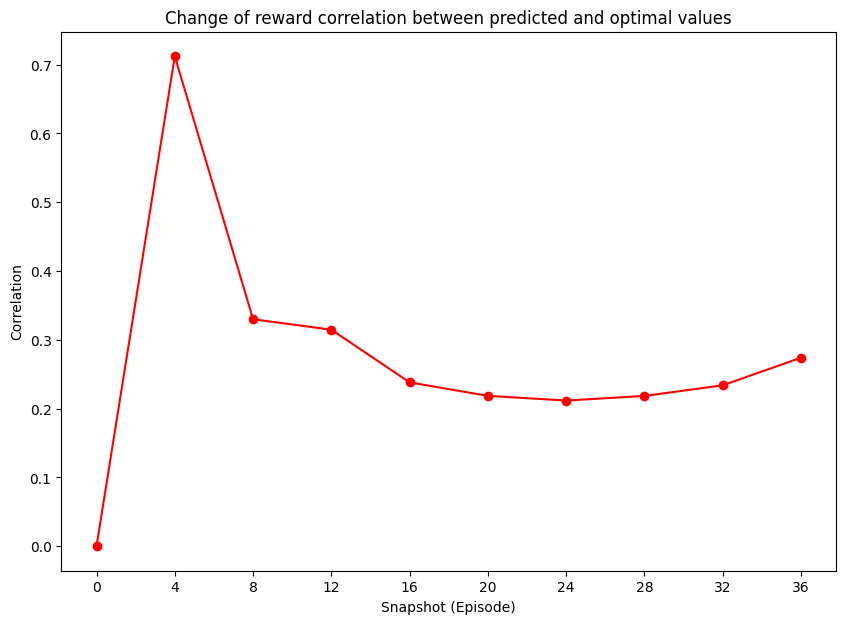

In [ ]:
snapshots = 9
dataStep = math.floor(len(userSequencePool[user_index]) / snapshots)
maximumCorrelationValues = []
actualCorrelationValues = []

# Maximum rewards per genre
maximumRewardsSum = np.zeros(18)
for ratingIndex, rating in enumerate(userSequencePool[user_index]):
  if ratingIndex % dataStep == 0:
    maximumCorrelationValues.append(np.array(maximumRewardsSum))
  for i, genre in enumerate(allGenres):
    if genre in rating[0]:
      if rating[1] == 2:
        maximumRewardsSum[i] += 0.3

      if rating[1] == 1:
        maximumRewardsSum[i] -= 0

      if rating[1] == 0:
        maximumRewardsSum[i] += 0.1

# Actual rewards per genre
actualRewardsSum = np.zeros(18)
rewardsOverTime = []
for ratingIndex, pair in enumerate(genreRewards):
  if ratingIndex % dataStep == 0:
    actualCorrelationValues.append(np.array(actualRewardsSum))
  rewardsOverTime.append(pair[1])
  actualRewardsSum[pair[0]] += pair[1]

# Correlation analysis
correlationValues = []
for corrValueIndex, corrValue in enumerate(maximumCorrelationValues):
  correlationValues.append(np.corrcoef(maximumCorrelationValues[corrValueIndex], actualCorrelationValues[corrValueIndex])[0][1])

correlationValues = np.where(np.isnan(correlationValues), 0, correlationValues)
labels = [i * dataStep for i in range(0, snapshots+1)]

plt.figure(figsize=(10,7))
plt.xlabel("Snapshot (Episode)")
plt.ylabel("Correlation")
plt.xticks(np.arange(0, snapshots+1), labels)
plt.yticks(np.arange(0, 1, step=0.1))
plt.plot(correlationValues, marker='o', color="red")
plt.title("Change of reward correlation between predicted and optimal values")


In [ ]:
user_id = 1
recommendations = agent.get_recommendations(1, 20)

1/1 [==============================] - 0s 25ms/step


In [ ]:

def prepare_ground_truth(user_ratings, all_genres):
    ground_truth = []
    for _, rating in user_ratings.iterrows():
        genres = rating['genres'].split(',')
        user_scores = [1 if genre in genres else 0 for genre in all_genres]
        ground_truth.append(user_scores)
    return ground_truth

In [ ]:
user_id = 1
user_ratings = ratings[ratings['userId'] == user_id]
ground_truth = prepare_ground_truth(user_ratings, allGenres)

In [ ]:
ground_truth

[[1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0],
 [0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0],
 [1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 1, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
def calculate_ap(predicted, actual):
    num_hits = 0
    precision_sum = 0.0
    for i, score in enumerate(predicted):
        if actual[i] == 1:
            num_hits += 1
            precision_sum += num_hits / (i + 1)
    if sum(actual) == 0:
        return 0.0
    return precision_sum / sum(actual)

def calculate_map(recommendations, ground_truth):
    map_sum = 0.0
    for i, predicted_scores in enumerate(recommendations):
        ground_truth_scores = ground_truth[i]
        sorted_indices = sorted(range(len(predicted_scores)), key=lambda i: predicted_scores[i], reverse=True)
        sorted_ground_truth = [ground_truth_scores[i] for i in sorted_indices]
        ap = calculate_ap(sorted_ground_truth, ground_truth_scores)
        map_sum += ap
    return map_sum / len(recommendations)

# Calculate MAP
map_score = calculate_map(recommendations, ground_truth)
print("Mean Average Precision (MAP): %.4f" % (map_score*10))

Mean Average Precision (MAP): 0.8083


In [ ]:
def calculate_dcg(scores, k):
    dcg = scores[0]
    for i in range(1, min(k, len(scores))):
        dcg += scores[i] / (log(i + 1) / log(2))
    return dcg

def calculate_ndcg(recommendations, ground_truth, k):
    ndcg_sum = 0.0
    for i, predicted_scores in enumerate(recommendations):
        ground_truth_scores = ground_truth[i]
        sorted_indices = sorted(range(len(predicted_scores)), key=lambda i: predicted_scores[i], reverse=True)
        sorted_ground_truth = [ground_truth_scores[i] for i in sorted_indices]
        dcg = calculate_dcg(sorted_ground_truth, k)
        idcg = calculate_dcg(sorted(ground_truth_scores, reverse=True), k)
        ndcg = dcg / idcg if idcg != 0 else 0.0
        ndcg_sum += ndcg
    return ndcg_sum / len(recommendations)


In [ ]:
from math import log
k = 10  # Assuming we want to calculate NDCG at top k

ndcg_score = calculate_ndcg(recommendations, ground_truth, k)
print("Normalized Discounted Cumulative Gain (NDCG@%d): %.4f" % (k, ndcg_score*10))

Normalized Discounted Cumulative Gain (NDCG@10): 0.9302
